In [1]:
# import datetime
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
from datlib.FRED import *
from datlib.plots import *
import pandas_datareader.data as web


#FRED.py
#. . . 
def bil_to_mil(series):
    return series* 10**3
# . . .
#fedProject.py
# . . .
data_codes  = {# Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Capital
               "Balance Sheet: Total Capital": "WCTCL",
               # Interest Rates
               "Unemployment Rate": "UNRATE",
               "Nominal GDP ($ Bil)":"GDP",
               "Real GDP ($ Bil)":"GDPC1",
               "GDP Deflator":"GDPDEF",
               "CPI":"CPIAUCSL",
               "Core PCE":"PCEPILFE",
               "Private Investment":"GPDI",
               "Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Bil)": "WCURCIR",
               "1 Month Treasury Rate (%)": "DGS1MO",
               "3 Month Treasury Rate (%)": "DGS3MO",               
               "1 Year Treasury Rate (%)": "DGS1",
               "2 Year Treasury Rate (%)": "DGS2",
               "10 Year Treasury Rate (%)": "DGS10",
               "30 Year Treasury Rate (%)": "DGS30",               
               "Effective Federal Funds Rate (%)": "DFF",
               "Federal Funds Target Rate (Pre-crisis)":"DFEDTAR",
               "Federal Funds Upper Target":"DFEDTARU",
               "Federal Funds Lower Target":"DFEDTARL",
               "Interest on Reserves (%)": "IOER",
               "VIX": "VIXCLS",
                "5 Year Forward Rate": "T5YIFR"
               }
inflation_target = 2
unemployment_target = 4
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
annual_div = {"Q":4,
             "W":52,
             "M":12}
last_month = 1
next_month = -1
next_year = -12

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
if "data_gathered" not in locals():
    freq = "M"
    year = annual_div[freq]
    data = gather_data(data_codes, start, 
          end = end, freq = freq)
    data.fillna(0, inplace=True)
    for key in data.keys():
        data["Log " + key]= np.log(data[key])
    # Create new variables
    data_gathered = True

ticker = "^GSPC"
data["Base: Currency in Circulation ($ Mil)"] = data["Base: Currency in Circulation ($ Bil)"].mul(1000)
data["Base: Currency not in Circulation ($ Mil)"] = data["Base: Total ($ Mil)"].sub(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation Growth Rate (%)"] = data["Base: Currency in Circulation ($ Mil)"].pct_change(year) * 100
data["Currency in Circulation Growth Rate Diff (%)"] =  data["Currency in Circulation Growth Rate (%)"].diff(year)
data["Currency in Circulation Growth Rate Diff-in-Diff (%)"] =  data["Currency in Circulation Growth Rate Diff (%)"].diff(year)

data["% Currency not in Circulation"] = data["Base: Currency not in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["% Currency in Circulation"] = data["Base: Currency in Circulation ($ Mil)"].div(data["Base: Total ($ Mil)"]) * 100
data["Base: Total Growth Rate (%)"] = data["Base: Total ($ Mil)"]
data["Change % Currency not in Circulation"] = data["% Currency not in Circulation"].diff(year)    
data["Currency not in Circulation Growth Rate (%)"] = data["Base: Currency not in Circulation ($ Mil)"].pct_change(year) * 100    
data["Inflation (CPI)"] =  web.DataReader("CPIAUCSL", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)#.shift(last_month).dropna()
data["Inflation (PCE)"] = web.DataReader("PCEPILFE", "fred", start, end).resample(freq).mean().pct_change(year).mul(100)#.shift(last_month).mul(100).dropna()

data["Effective Federal Funds Rate Diff (%)"] = data["Effective Federal Funds Rate (%)"].diff(year)
data["Effective Federal Funds Rate Diff-in-Diff (%)"] = data["Effective Federal Funds Rate Diff (%)"].diff(year)
data["1 Year Treasury Rate (%; diff)"] = data["1 Year Treasury Rate (%)"].diff(year)
data["2 Year Treasury Rate (%; diff)"] = data["2 Year Treasury Rate (%)"].diff(year)
data["10 Year Treasury Rate (%; diff)"] = data["10 Year Treasury Rate (%)"].diff(year)
data["30 Year Treasury Rate (%; diff)"] = data["30 Year Treasury Rate (%)"].diff(year)
data["Unemployment Rate Diff"] = data["Unemployment Rate"].diff(year)
data["Unemployment Rate Diff-in-Diff"] = data["Unemployment Rate Diff"].diff(year)
data["Nominal GDP ($ Mil)"] = data["Nominal GDP ($ Bil)"].mul(1000)
data["Nominal GDP Growth Rate (%)"] = data["Nominal GDP ($ Bil)"].pct_change(year) * 100
data["Real GDP ($ Mil)"] = data["Real GDP ($ Bil)"].mul(1000)
data["Real GDP Growth Rate (%)"] = data["Real GDP ($ Bil)"].pct_change(year) * 100
data["Inflation (GDPDEF)"] = data["GDP Deflator"].pct_change(year) * 100
data["Real Currency in Circulation Growth Rate (%)"] = data["Currency in Circulation Growth Rate (%)"].sub(data["Inflation (GDPDEF)"])
data["Currency in Circulation Velocity"] = data["Nominal GDP ($ Mil)"].div(data["Base: Currency in Circulation ($ Mil)"])
data["Currency in Circulation % Change Velocity"] = data["Currency in Circulation Velocity"].pct_change(year)

data["Inflation Loss"]= data["Inflation (PCE)"].sub(inflation_target)
data["Unemployment Loss"]= data["Unemployment Rate"].sub(unemployment_target)
data["Inflation Loss Sq"]= data["Inflation (PCE)"].sub(inflation_target).pow(2)
data["Inflation Loss Sq"][data["Inflation Loss"] < 0] = data["Inflation Loss Sq"].mul(-1)

data["Unemployment Loss Sq"]= data["Unemployment Rate"].sub(unemployment_target).pow(2)
data["Unemployment Loss Sq"][data["Unemployment Loss"] < 0] = data["Unemployment Loss Sq"].mul(-1)



data["Inflation Loss Diff"]= data["Inflation Loss"].diff(year)
data["Unemployment Loss Diff"]= data["Unemployment Loss"].diff(year)
data["Inflation Loss Sq Diff"]= data["Inflation Loss Sq"].diff(year)
data["Unemployment Loss Sq Diff"]= data["Unemployment Loss Sq"].diff(year)

data["Inflation Loss Diff-in-Diff"]= data["Inflation Loss Diff"].diff(year)
data["Unemployment Loss Diff-in-Diff"]= data["Unemployment Loss Diff"].diff(year)
data["Inflation Loss Sq Diff-in-Diff"]= data["Inflation Loss Sq Diff"].diff(year)
data["Unemployment Loss Sq Diff-in-Diff"]= data["Unemployment Loss Sq Diff"].diff(year)


data["Linear Loss"] = data["Inflation Loss"].sub(data["Unemployment Loss"])
data["Loss Function"] = data["Inflation Loss Sq"].sub(data["Unemployment Loss Sq"])
data["Linear Loss Diff"] = data["Linear Loss"].diff(year)
data["Loss Function Diff"] = data["Loss Function"].diff(year)
data["Linear Loss Diff-in-Diff"] = data["Linear Loss Diff"].diff(year)
data["Loss Function Diff-in-Diff"] = data["Loss Function Diff"].diff(year)

data["Real 1 Year Treasury Rate"] = data["1 Year Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 3 Month Treasury Rate"] = data["3 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real 1 Month Treasury Rate"] = data["1 Month Treasury Rate (%)"].sub(data["Inflation (CPI)"])
data["Real Effective Federal Funds Rate"] = data['Effective Federal Funds Rate (%)'].sub(data["Inflation (CPI)"])

data["30 Year Minus 1 Year (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["30 Year Minus 3 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["30 Year Minus 1 Month (%)"] = data["30 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["30 Year Minus Effective Federal Funds Rate"] = data["30 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])
data["10 Year Minus 2 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["2 Year Treasury Rate (%)"])
data["10 Year Minus 1 Year (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Year Treasury Rate (%)"])
data["10 Year Minus 3 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["3 Month Treasury Rate (%)"])
data["10 Year Minus 1 Month (%)"] = data["10 Year Treasury Rate (%)"].sub(data["1 Month Treasury Rate (%)"])
data["10 Year Minus Effective Federal Funds Rate"] = data["10 Year Treasury Rate (%)"].sub(data['Effective Federal Funds Rate (%)'])

keys = list(data.keys())
keys = ["Date"] + keys
data["Date"] = data.index.astype(str)



C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2]:
data["Unemployment Rate"]

DATE
2002-12-31    6.0
2003-01-31    5.8
2003-02-28    5.9
2003-03-31    5.9
2003-04-30    6.0
             ... 
2021-06-30    5.9
2021-07-31    5.4
2021-08-31    5.2
2021-09-30    4.8
2021-10-31    0.0
Freq: M, Name: Unemployment Rate, Length: 227, dtype: float64

In [3]:
import yfinance as yfin
yfin.pdr_override()
data["S&P"]= web.get_data_yahoo(ticker, start = start, end = end).resample(freq).mean()["Close"].iloc[:-2]
data["S&P Growth Rate (%)"] = data["S&P"].pct_change(year)
data["S&P Growth Rate Change Diff (%)"] = data["S&P Growth Rate (%)"].diff(year)
data["Real S&P Growth Rate (%)"] = data["S&P Growth Rate (%)"].sub(data["Inflation (CPI)"])
data["VIX Diff"] = data["VIX"].diff(year)
data

[*********************100%***********************]  1 of 1 completed


,Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),Balance Sheet: Direct Lending ($ Mil),Balance Sheet: Unamortized Security Premiums ($ Mil),...,10 Year Minus 1 Year (%),10 Year Minus 3 Month (%),10 Year Minus 1 Month (%),10 Year Minus Effective Federal Funds Rate,Date,S&P,S&P Growth Rate (%),S&P Growth Rate Change Diff (%),Real S&P Growth Rate (%),VIX Diff
DATE,,,,,,,,,,,,,,,,,,,,,
2002-12-31,725800.50,672844.50,629409.50,629399.50,10.0,0.00,33625.0,0.0,52.00,10811.00,...,2.582381,2.821429,2.834762,2.793994,2002-12-31,899.178574,NaN,NaN,NaN,NaN
2003-01-31,724718.40,671196.20,629416.00,629406.00,10.0,0.00,32100.0,0.0,19.40,10688.00,...,2.684286,2.859524,2.878095,2.813410,2003-01-31,895.836190,NaN,NaN,NaN,NaN
2003-02-28,721326.00,668666.25,631911.75,631901.75,10.0,0.00,27185.5,0.0,10.50,10571.25,...,2.606316,2.717368,2.707368,2.640489,2003-02-28,837.618951,NaN,NaN,NaN,NaN
2003-03-31,723651.25,672446.00,639168.25,639158.25,10.0,0.00,23625.0,0.0,11.00,10619.25,...,2.567143,2.656190,2.630952,2.554240,2003-03-31,846.621425,NaN,NaN,NaN,NaN
2003-04-30,736926.40,685518.60,645508.60,645498.60,10.0,0.00,30350.2,0.0,31.80,10574.40,...,2.691429,2.806190,2.800476,2.700571,2003-04-30,890.025713,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.0,516.0,87694.60,350797.60,...,1.452273,1.483182,1.491818,1.441091,2021-06-30,4238.489546,0.365202,0.290987,-4.959306,-14.162727
2021-07-31,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.0,487.0,87349.25,352744.75,...,1.242857,1.266190,1.269048,1.220507,2021-07-31,4363.712798,0.360421,0.289828,-4.922173,-9.237121
2021-08-31,8291893.25,8153497.75,7733453.75,5312788.25,2347.0,2418318.75,0.0,446.0,81331.75,353699.00,...,1.209545,1.228636,1.241818,1.190924,2021-08-31,4453.965931,0.313192,0.142608,-4.889285,-5.416797


In [4]:
#fedProject
# . . . 
data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"] =\
    data["Balance Sheet: Central Bank Liquidity Swaps ($ Mil)"].add(
    data["Balance Sheet: Direct Lending ($ Mil)"])
data["Balance Sheet: Other Securities"] = data["Balance Sheet: Securities Held Outright ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasuries Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Mortgage-Backed Securities ($ Mil)"])
data["Balance Sheet: Other Assets"] = data["Balance Sheet: Total Assets ($ Mil)"].sub(
    data["Balance Sheet: Securities Held Outright ($ Mil)"]).sub(
    data["Balance Sheet: Direct Lending and Central Bank Liquidity Swaps"]).sub(
    data["Balance Sheet: Repos ($ Mil)"]).sub(
    data["Balance Sheet: Unamortized Security Premiums ($ Mil)"])
data["Balance Sheet: Other Deposits ($ Mil)"] = data["Balance Sheet: All Deposits ($ Mil)"].sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"])
data["Balance Sheet: Other Liabilities"]= data["Balance Sheet: Total Liabilities ($ Mil)"].sub(
    data["Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)"]).sub(
    data["Balance Sheet: U.S. Treasury General Account ($ Mil)"]).sub(
    data["Balance Sheet: Deposits from Dep. Institutions ($ Mil)"]).sub(
    data["Balance Sheet: Other Deposits ($ Mil)"]).sub(
    data["Balance Sheet: Reverse Repos ($ Mil)"])


<ipython-input-5-3df2aa4fa2c4>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])


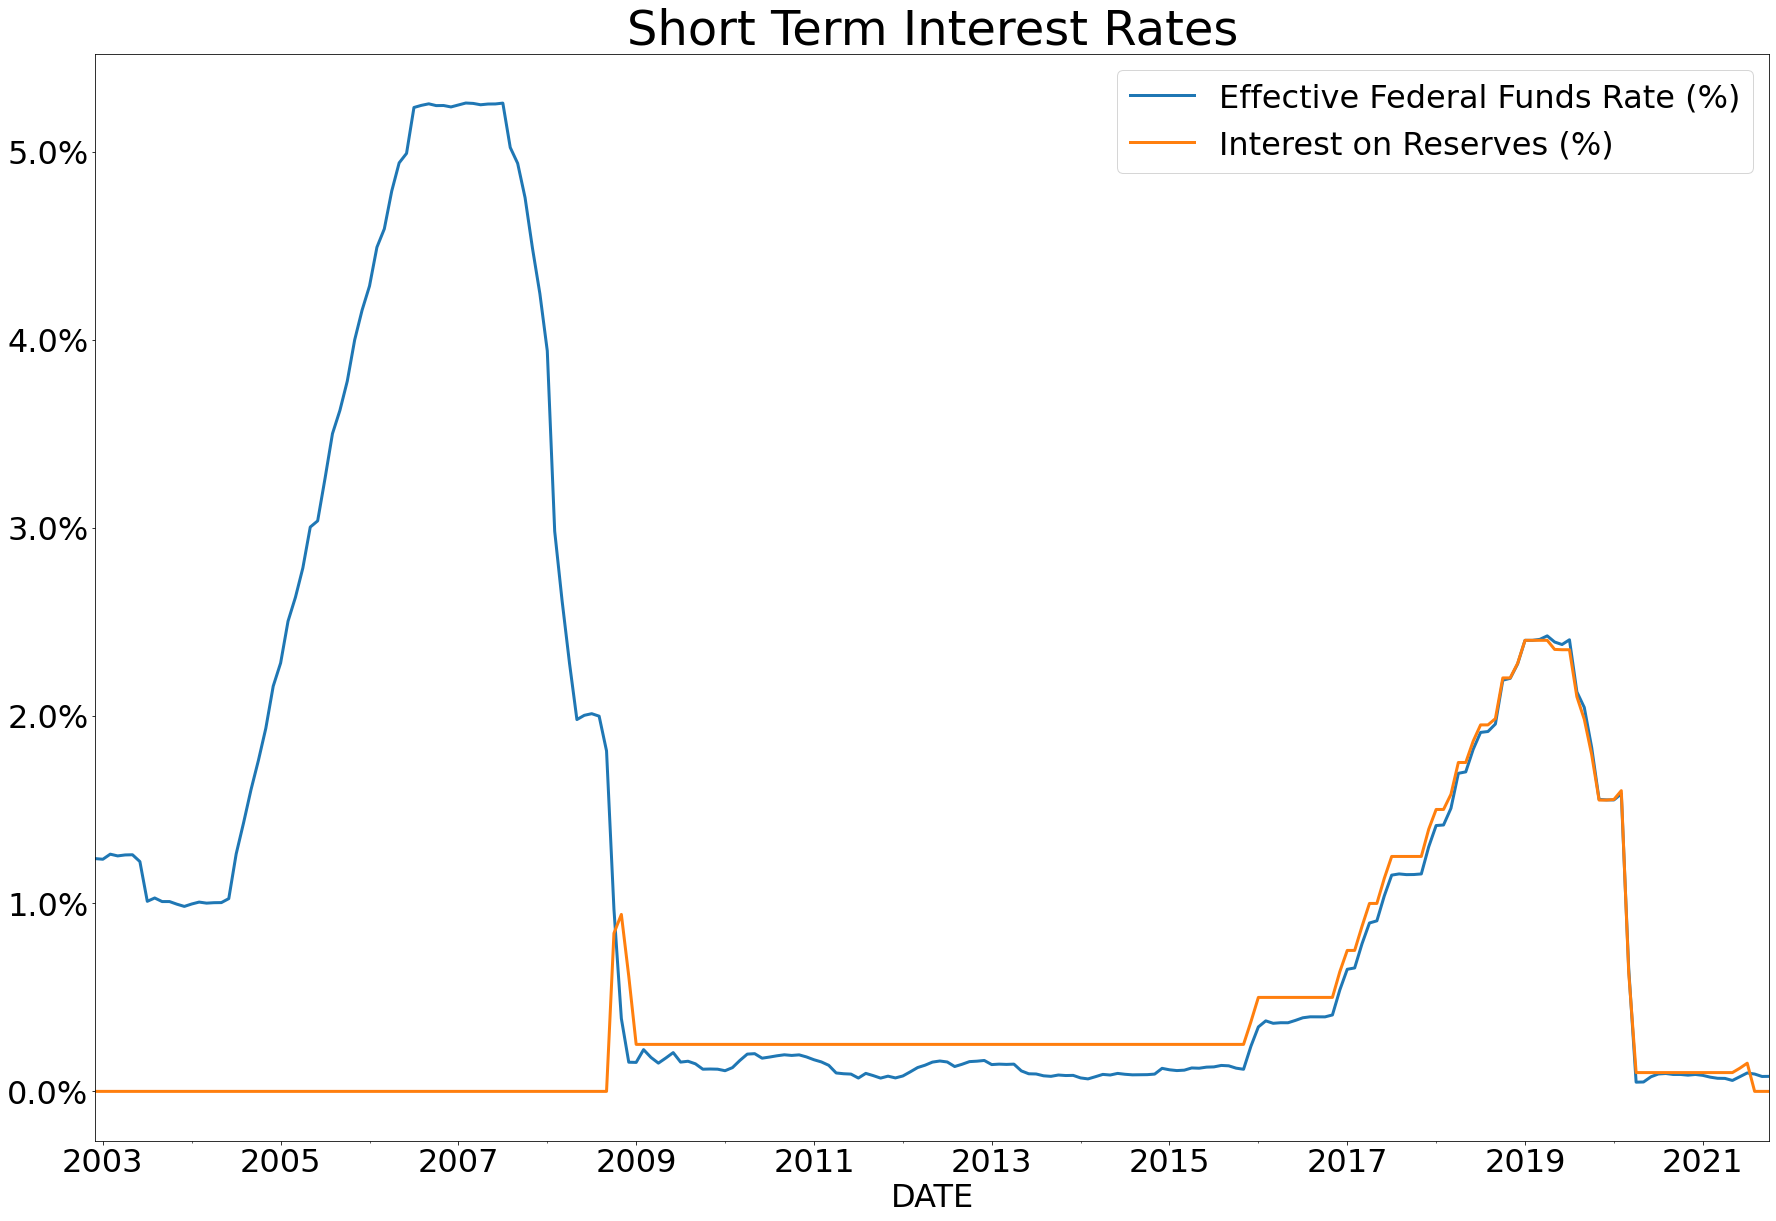

In [5]:
plt.rcParams.update({"font.size":32})
interest_vars = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)"]
fig, ax = plt.subplots(figsize = (30,20))
data[interest_vars].plot.line(legend=True, linewidth = 3, ax = ax)
y_vals = ax.get_yticks()
ax.set_yticklabels([str(round(y,2))+ "%" for y in y_vals])  
ax.set_title("Short Term Interest Rates", fontsize = 48)
data[["Date"] + interest_vars].to_json("shortTermRates.json", orient="records")

In [6]:
data = data.rename(columns = {
    key: key.replace("Balance Sheet: ", "").replace(" ($ Mil)", "").replace("Base: ","") for key in data.keys()})
keys = list(data.keys())
interest_rates = ["Effective Federal Funds Rate (%)",
                   "Interest on Reserves (%)",
                   "1 Month Treasury Rate (%)"]
plot_data = data.copy()
for key, val in data.items():
    if key not in interest_rates:
        try:
            plot_data[key] = val.div(10**6)
        except:
            continue

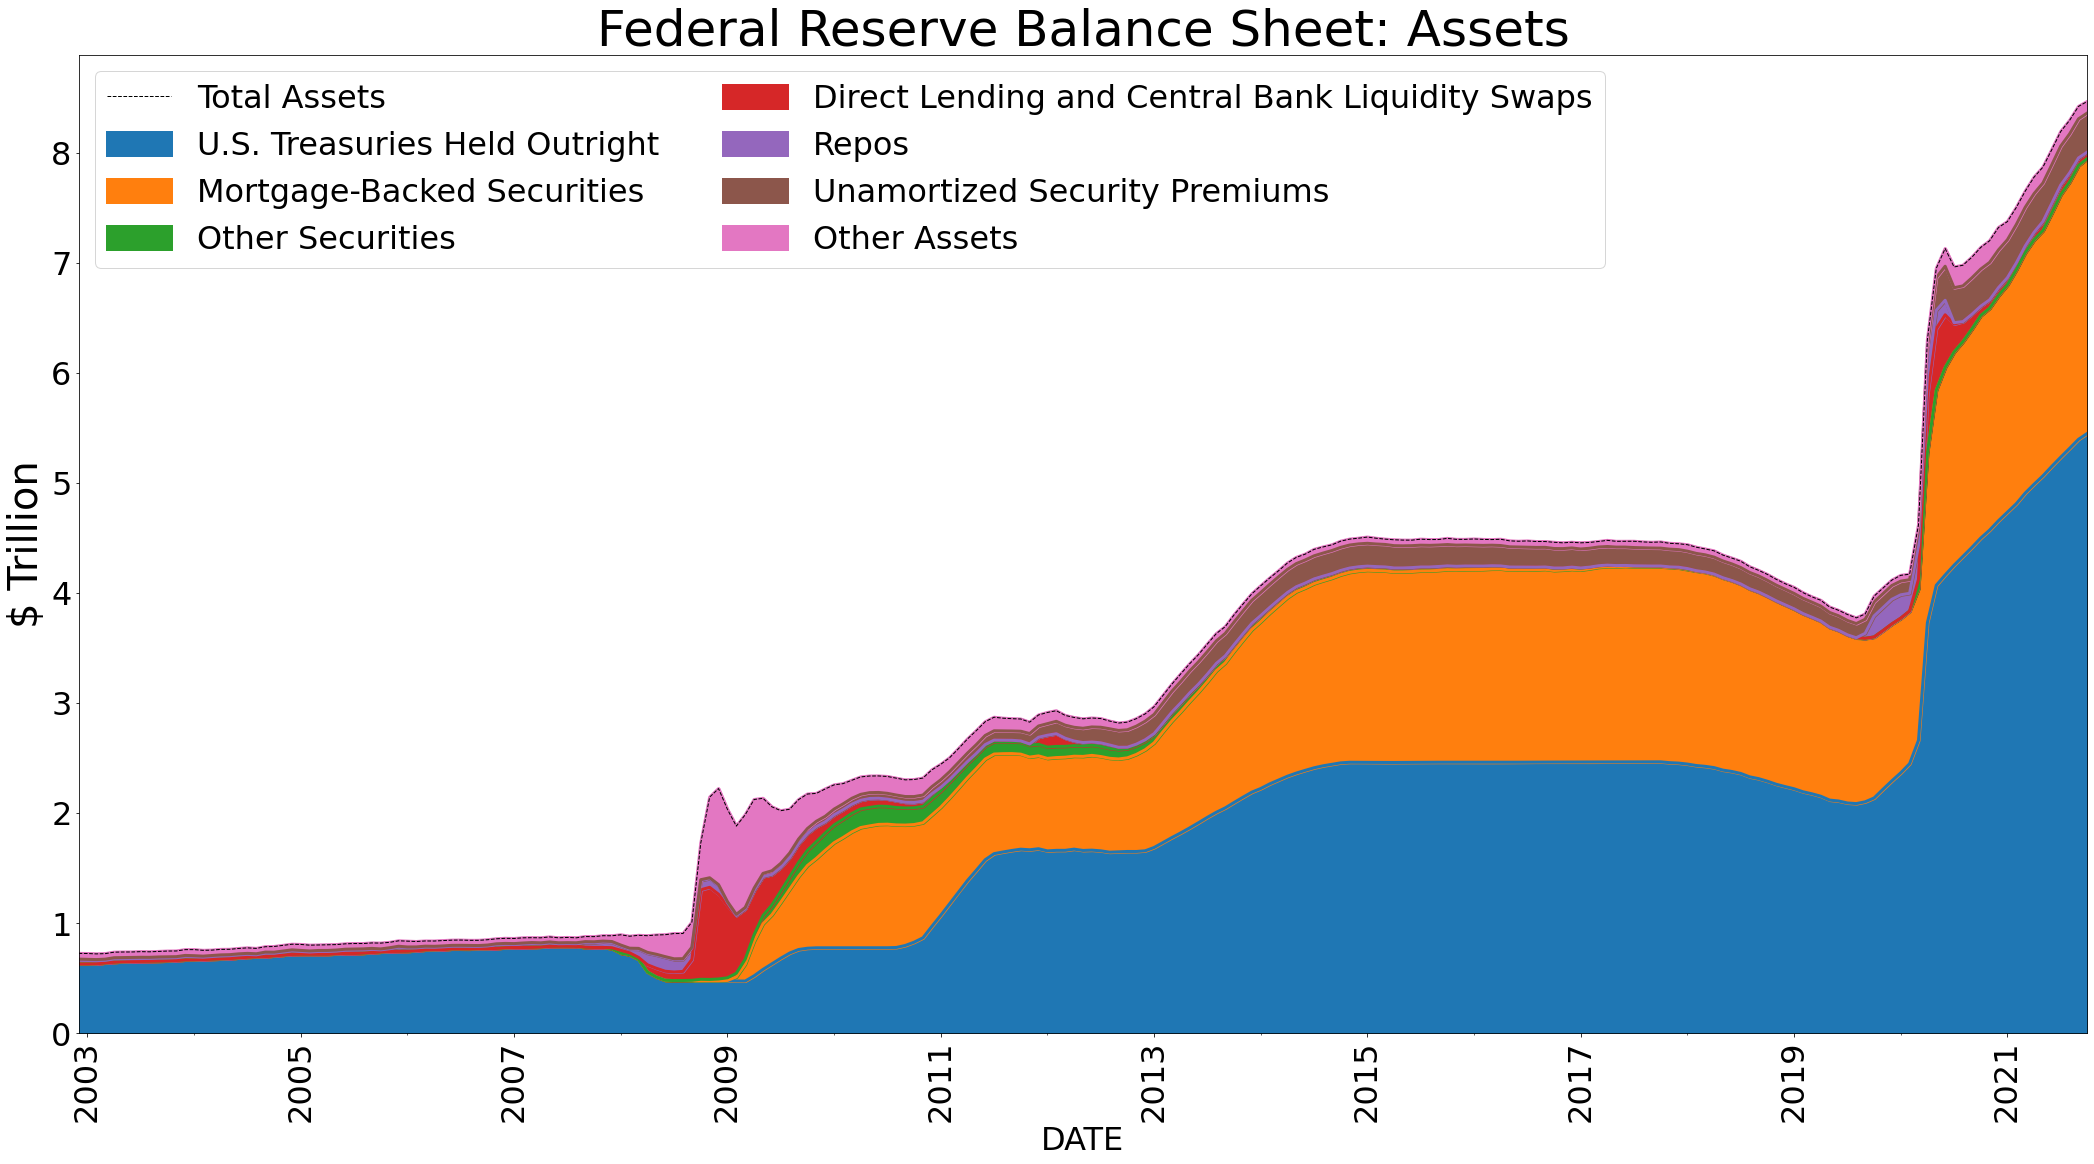

In [7]:
account_vars = ["U.S. Treasuries Held Outright",
               "Mortgage-Backed Securities",
               "Other Securities",
               "Direct Lending and Central Bank Liquidity Swaps",
               "Repos",
               "Unamortized Security Premiums",
               "Other Assets"]
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Assets"
plot_data[total_var].plot.line(linewidth = 1, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Assets", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveAssets.csv")
plot_data[["Date"] + account_vars].to_json("fedAssets.json", orient = "records")

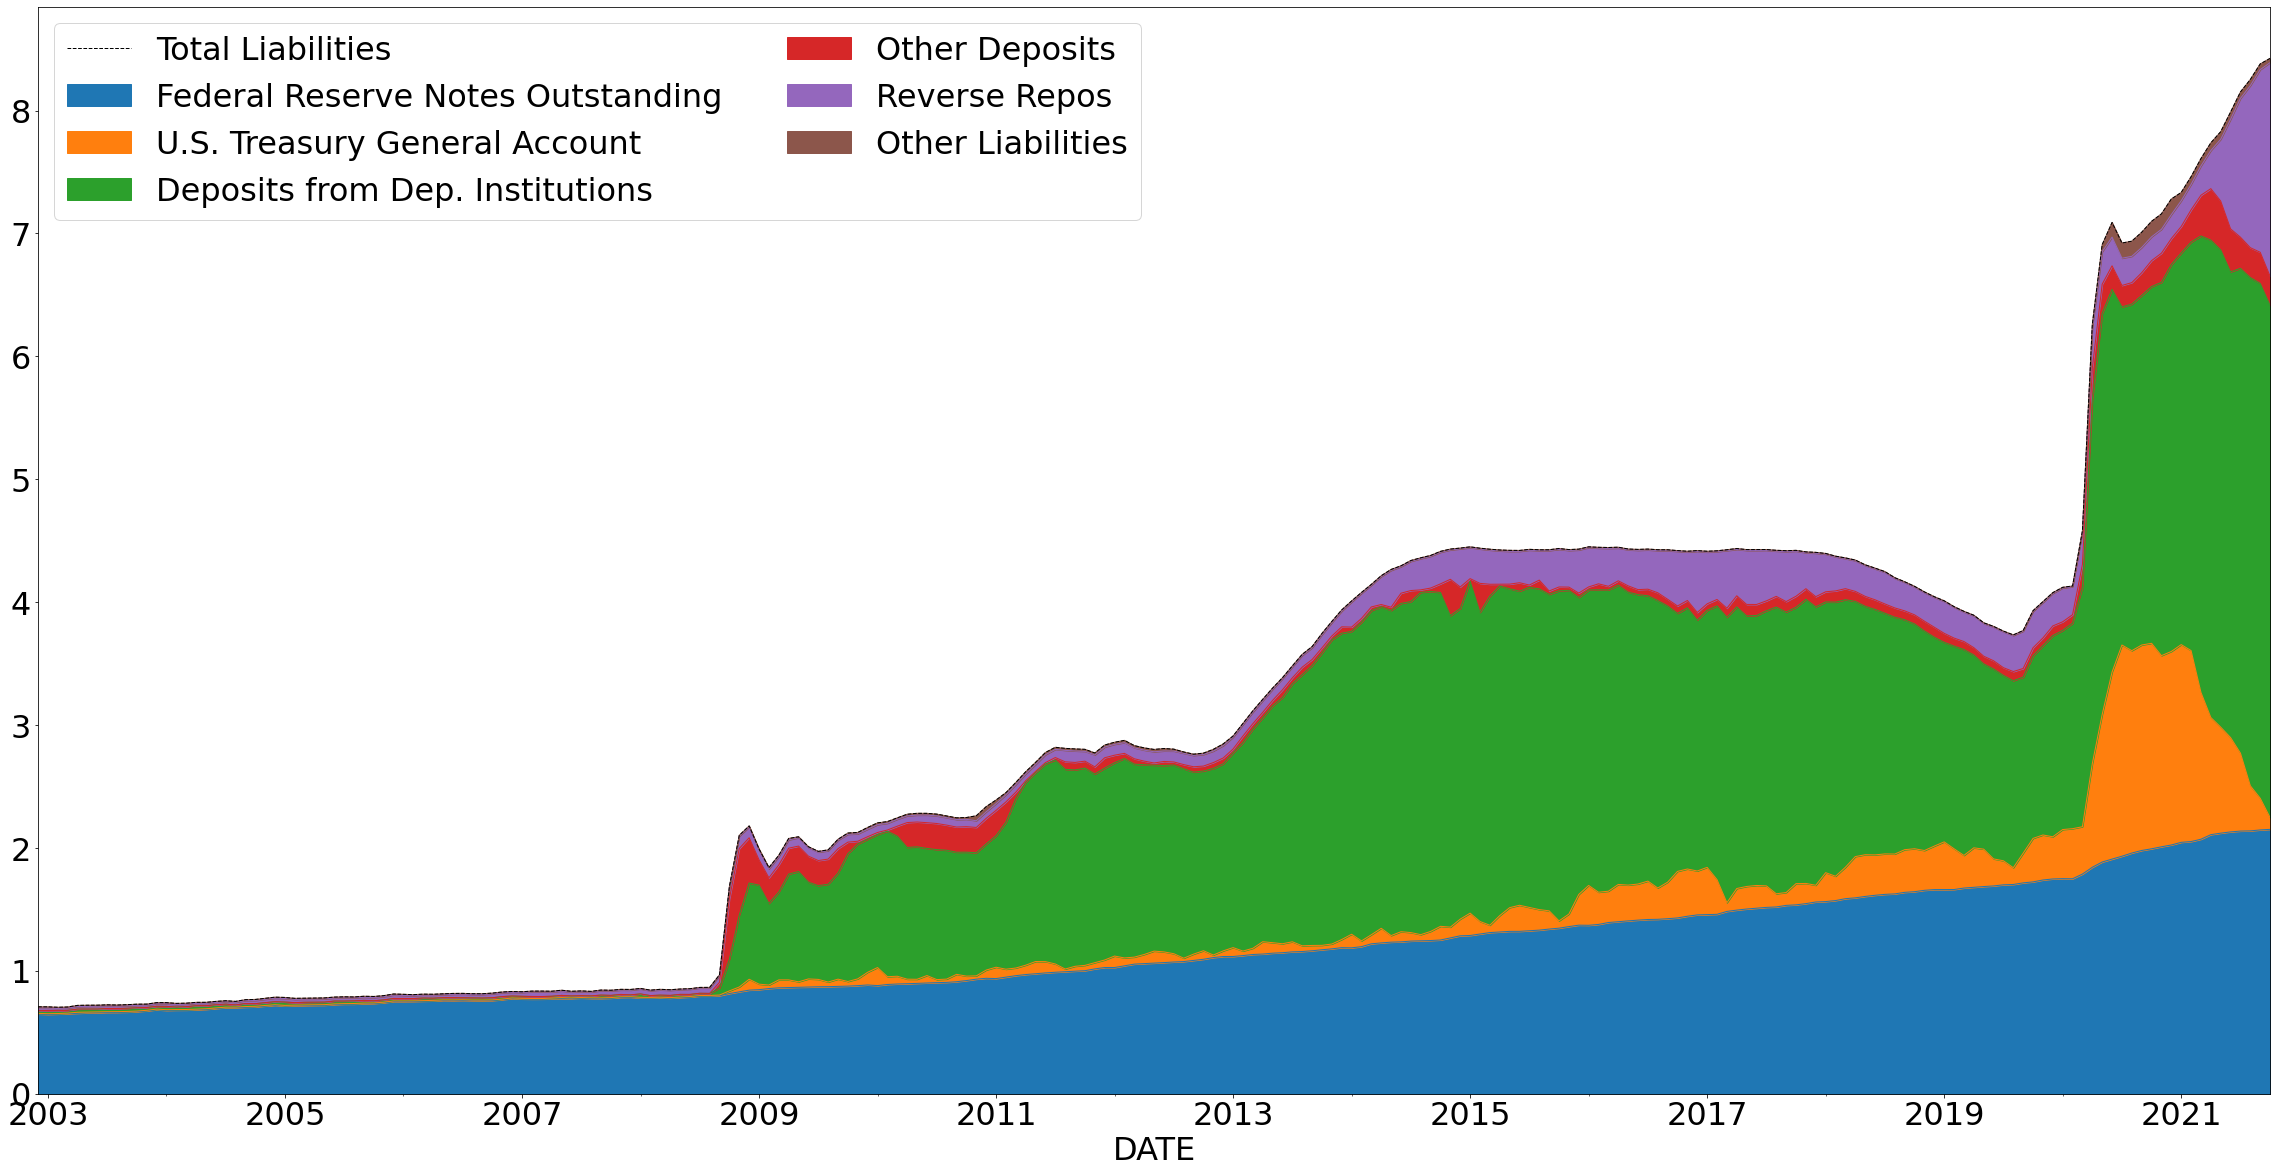

In [8]:
account_vars = ["Federal Reserve Notes Outstanding",
                "U.S. Treasury General Account",
                "Deposits from Dep. Institutions",
                "Other Deposits",
                "Reverse Repos",
                "Other Liabilities"]
total_var = "Total Liabilities"

plot_stacked_lines(
    plot_data,
    account_vars, linewidth = 1,
    total_var = "Total Liabilities")


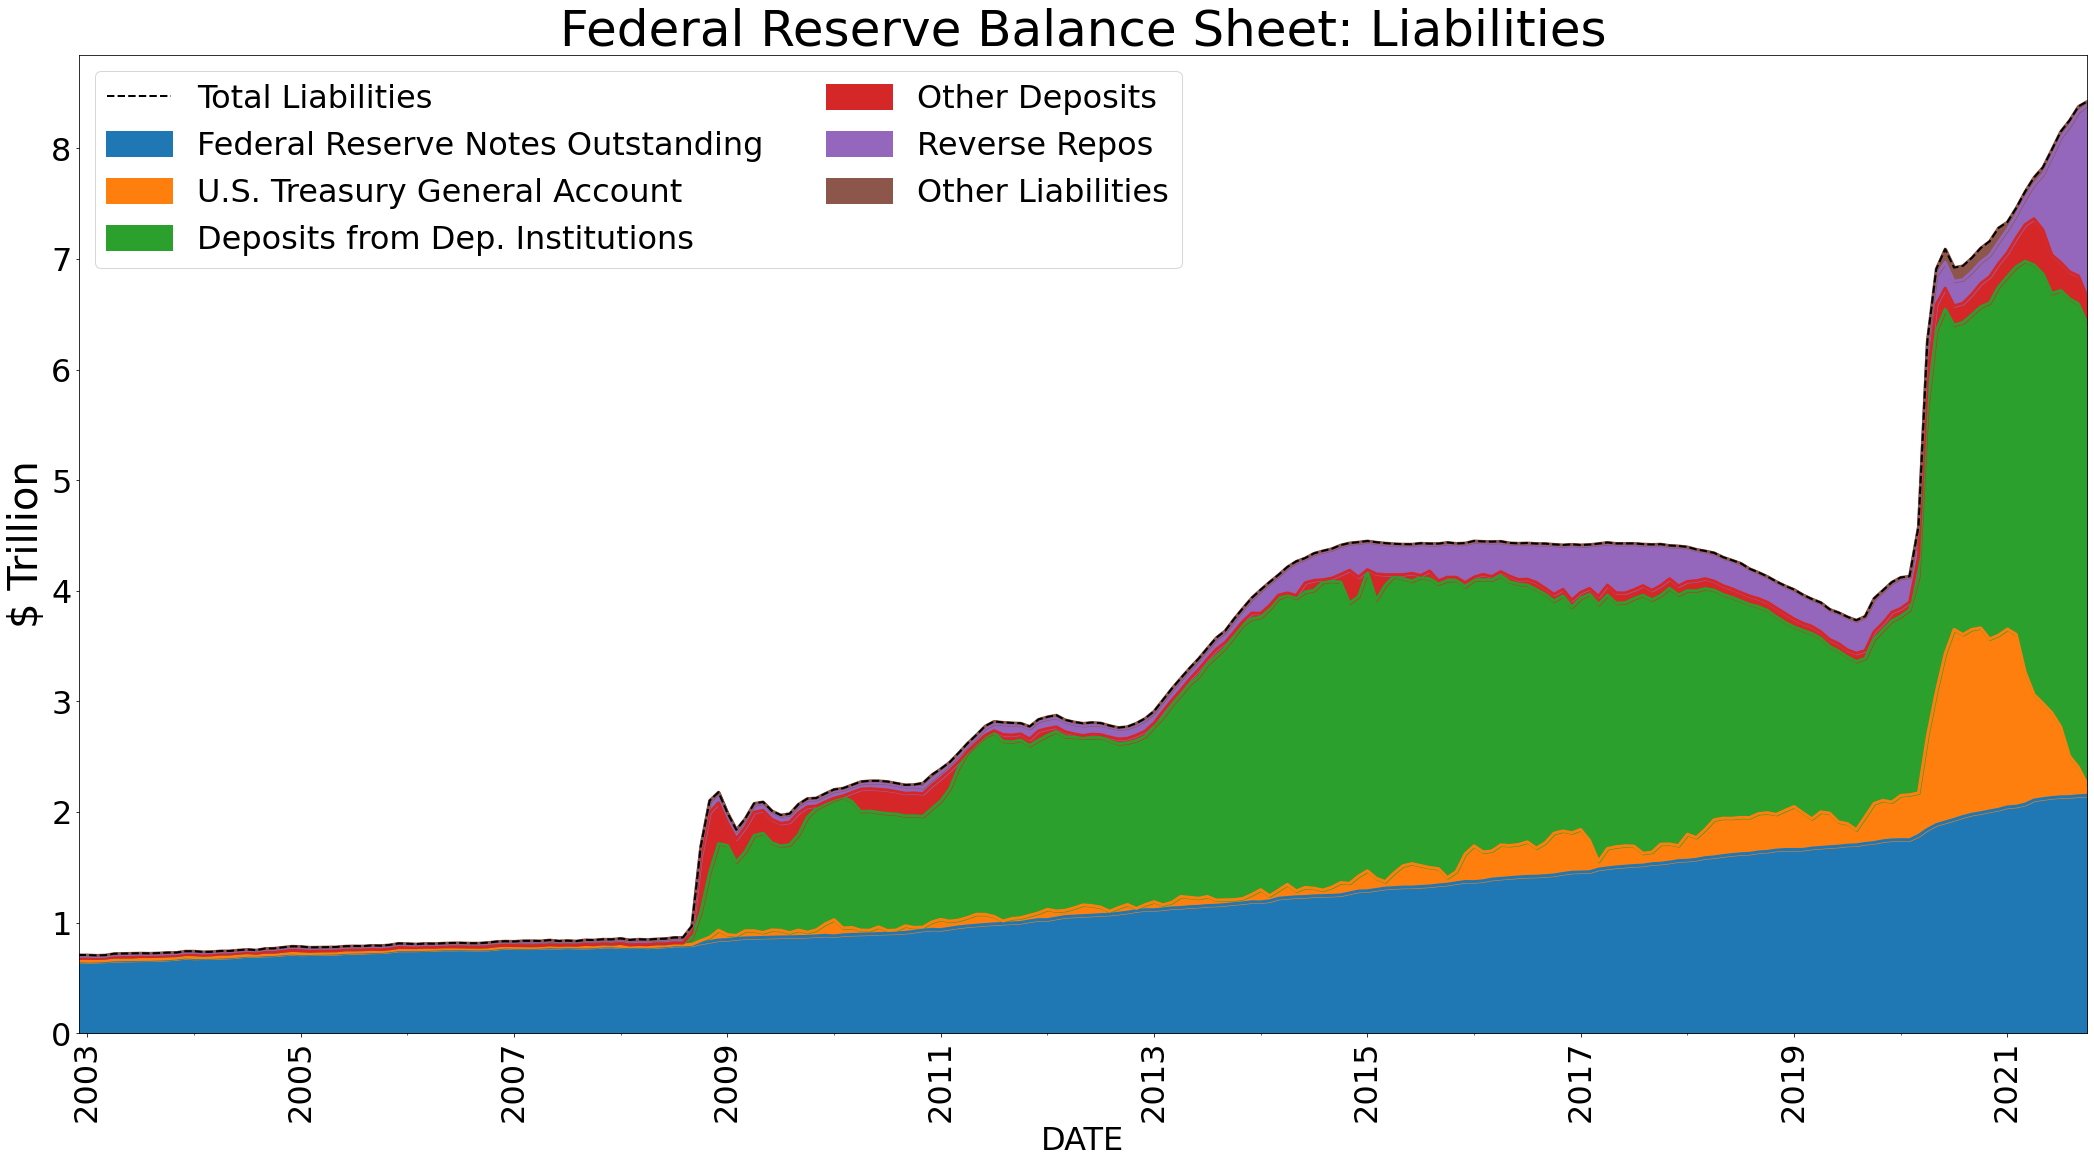

In [9]:
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
plot_data[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
# change y vals from mil to tril
total_var = "Total Liabilities"
plot_data[total_var].plot.line(linewidth = 2, 
                             ax = ax, c = "k",
                             label = total_var, ls = "--")
plt.xticks(rotation = 90)
ax.legend(loc=2, ncol = 2)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Balance Sheet: Liabilities", fontsize = 50)
plot_data[[total_var] + account_vars].to_csv("FederalReserveLiabilities.csv")

<ipython-input-10-bd89c59b9c46>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)


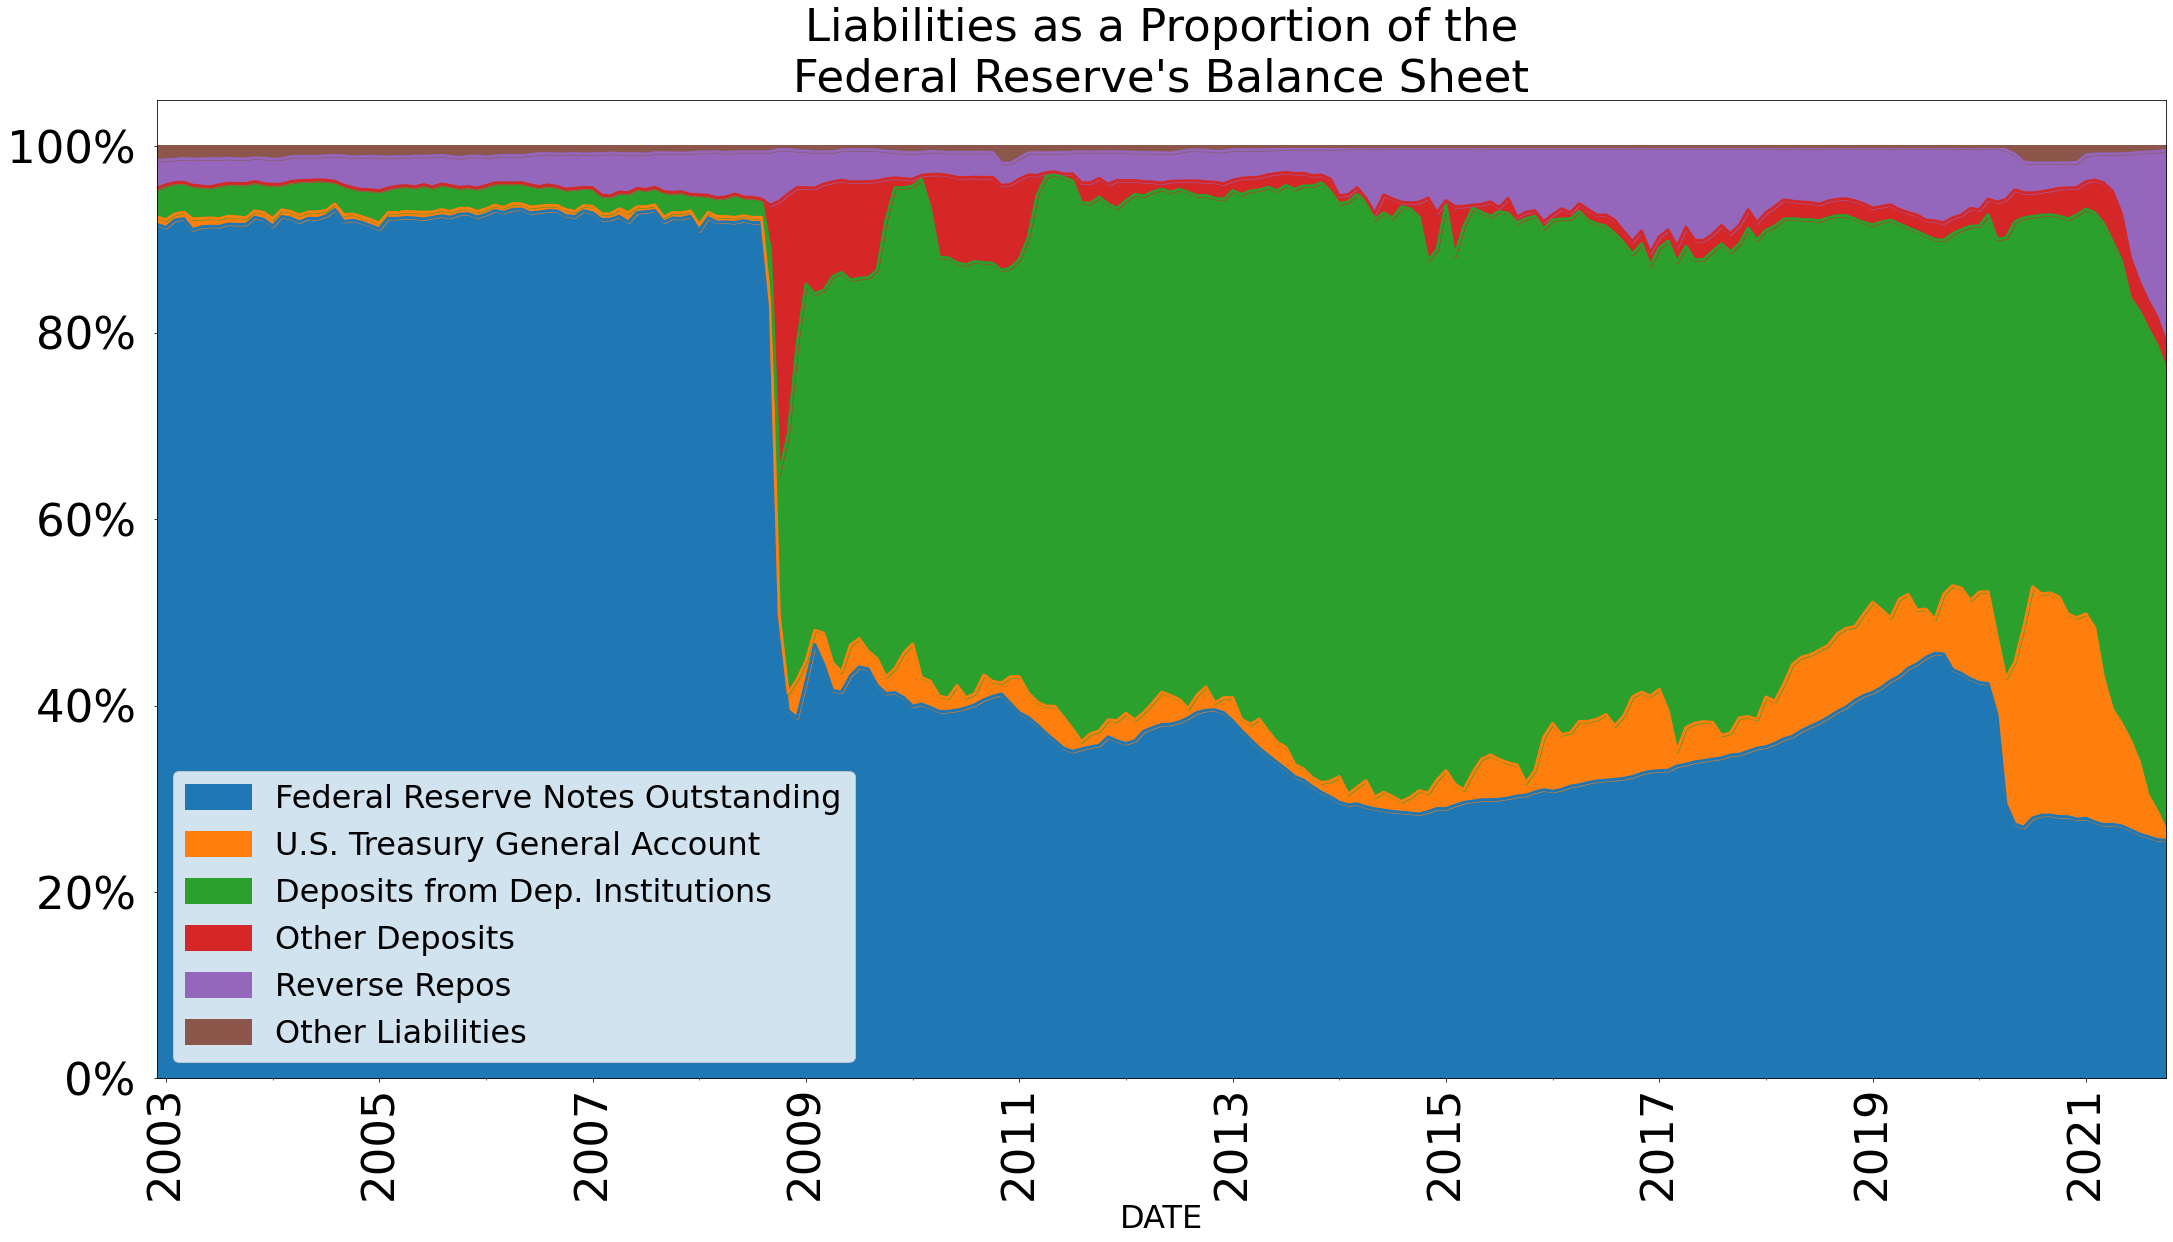

In [10]:
plt.rcParams.update({"font.size":32})
df = plot_data.copy()
for key in account_vars:
    df[key] = df[key].div(df["Total Liabilities"])
figsize= (36,18)
fig, ax = plt.subplots(figsize = figsize)
df[account_vars].plot.area(stacked = True, linewidth = 3,
                            ax = ax)
plt.xticks(rotation= 90, fontsize = 45)
ax.set_yticklabels([str(int(val * 100)) + "% " for val in ax.get_yticks()], fontsize = 45)

#plt.yticks([int(tick * 100) for tick in ax.get_yticks() if tick <1.01])
plt.title("Liabilities as a Proportion of the\nFederal Reserve's Balance Sheet", fontsize =45)
plt.show()


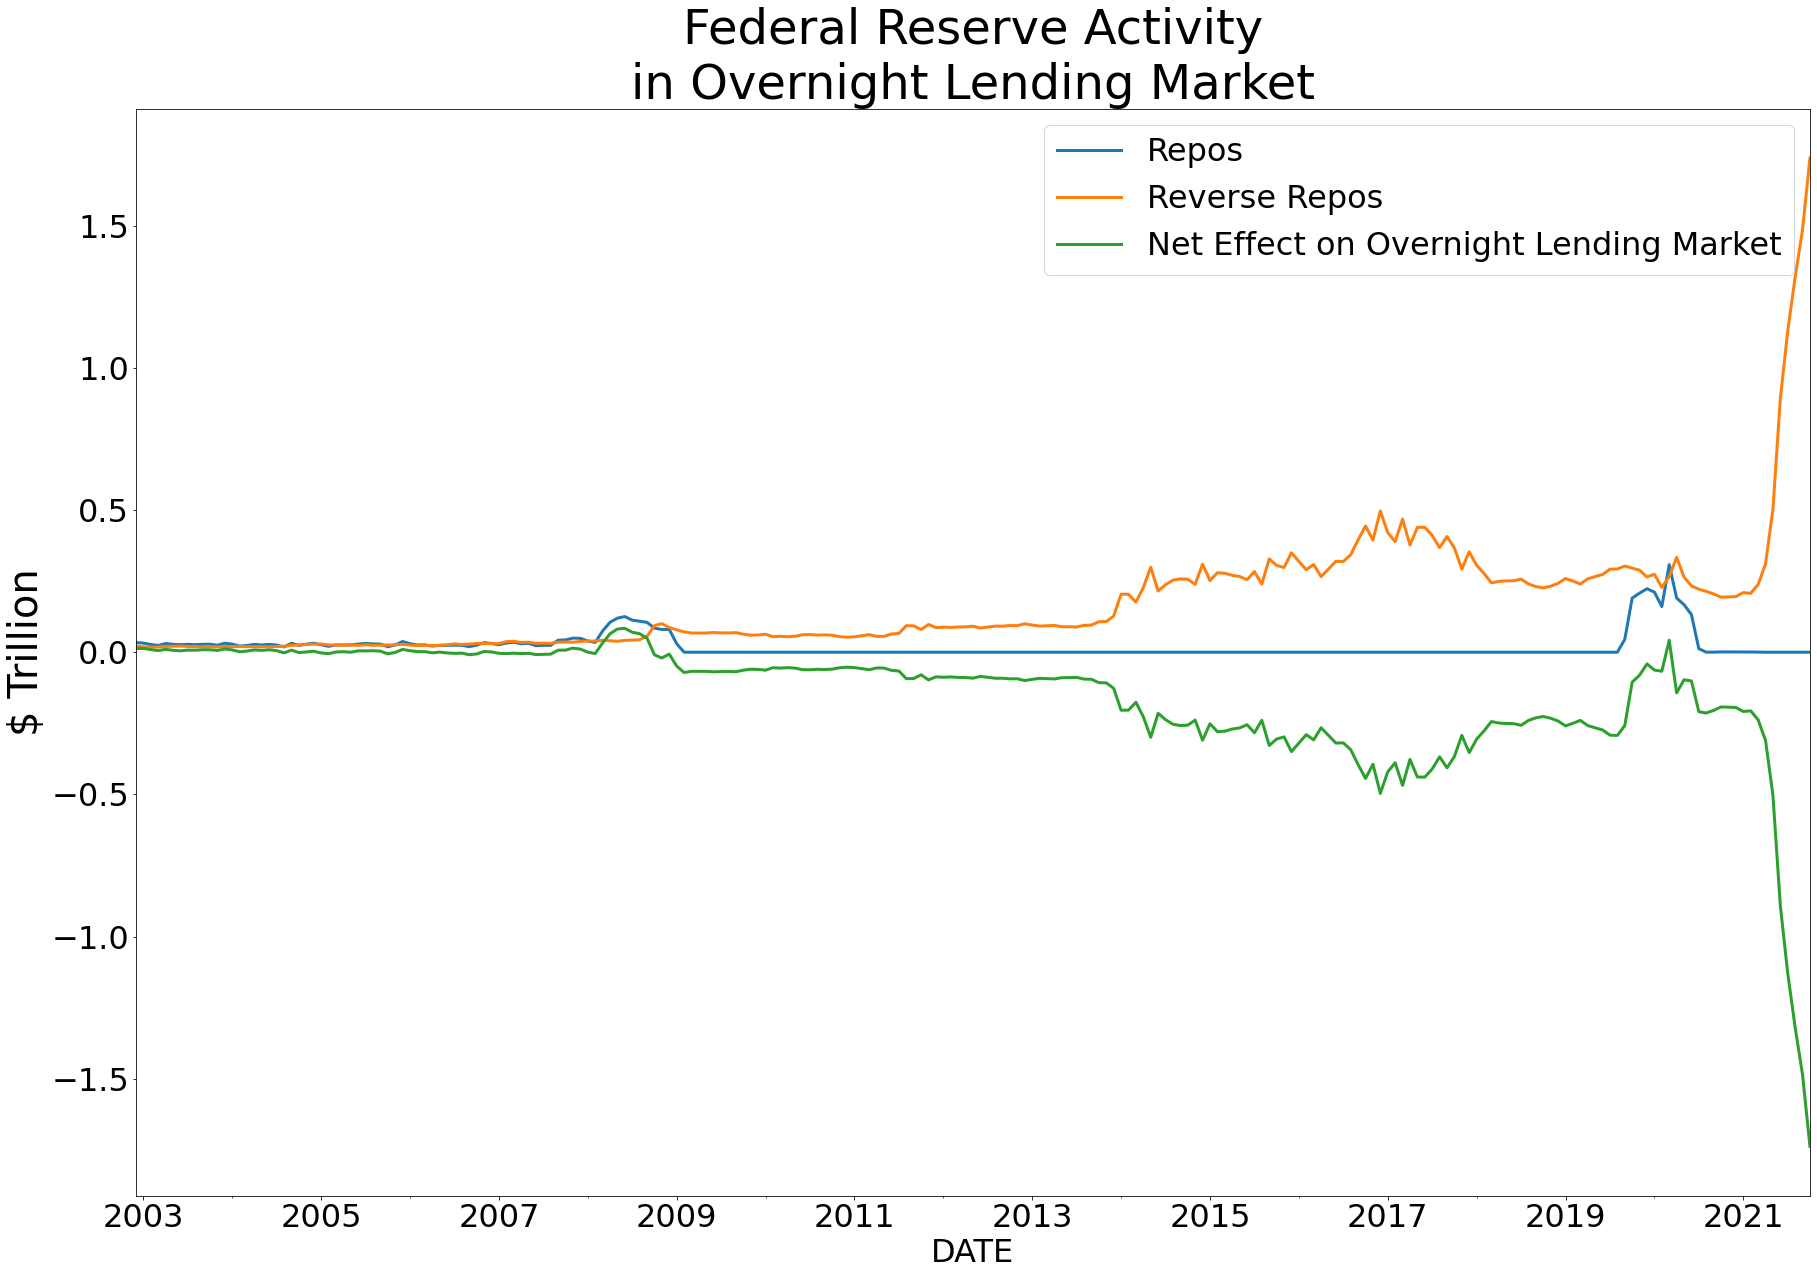

In [11]:
plot_data["Net Effect on Overnight Lending Market"] =\
    plot_data["Repos"].sub(plot_data["Reverse Repos"])
overnight_vars = ["Repos",
                  "Reverse Repos",
                  "Net Effect on Overnight Lending Market"]
fig, ax = plt.subplots(figsize = (30,20))
plot_data[overnight_vars].plot.line(legend=True, linewidth = 3, ax = ax)
ax.set_ylabel("$ Trillion", fontsize = 40)
ax.set_title("Federal Reserve Activity\nin Overnight Lending Market", fontsize = 48)
plot_data[["Date"] + overnight_vars].to_json("overnightLending.json", orient="records")


In [12]:
data["Total Liabilities Growth Rate (%)"] = data["Total Liabilities"].pct_change(year)
data["Total Assets Growth Rate (%)"] = data["Total Assets"].pct_change(year)
data["Total Assets Growth Rate Diff (%)"] = data["Total Assets Growth Rate (%)"].diff(year)
data["Total Assets Growth Rate Diff-in-Diff (%)"] = data["Total Assets Growth Rate Diff (%)"].diff(year)

data["Total Liabilities / Currency in Circulation"] = data["Total Liabilities"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Total Assets / Currency in Circulation"] = data["Total Assets"].div(data["Currency in Circulation ($ Bil)"].mul(1000))
data["Currency in Circulation / Total Assets"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Assets"]).mul(100)
data["Currency in Circulation / Total Assets Diff"] = data["Currency in Circulation / Total Assets"].diff(year)
data["Currency in Circulation / Total Assets Diff-in-Diff"] = data["Currency in Circulation / Total Assets Diff"].diff(year)
data["Currency in Circulation / Total Liabilities"] = data["Currency in Circulation ($ Bil)"].mul(1000).div(data["Total Liabilities"])
data["Currency in Circulation / Total Liabilities Diff"] = data["Currency in Circulation / Total Liabilities"].diff(year)

data["Log Total Liabilities"] = np.log(data["Total Liabilities"])
data["Log Total Assets"] = np.log(data["Total Assets"])
#data["Currency in Circulation / Total Liabilities %"] = data["Currency in Circulation / Total Liabilities"].pct_change()


In [13]:
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
data.to_parquet("FedDAGData.parquet.gzip", compression = "gzip",
                    engine = "pyarrow")


In [27]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
import statsmodels.api as sm
import copy
import pingouin
from scipy.stats import pearsonr
p_val = .05
def formatted_scatter_matrix(data, pp, title = ""):  
    # Create a figure showing scatterplots given in scatter_cats  
    fig_len = 12  
    fig, ax = plt.subplots(figsize = ((fig_len, fig_len)))  
    # Use fig_len to dictate fig_size, adjust size of font, size of dots, etc...  
    num_vars = len(data.keys())  
    fontsize = 26
    plt.rcParams.update({'font.size': fontsize})  
    pd.plotting.scatter_matrix(data.rename(columns={col:col.replace(" ", "\n") for col in data})
                               ,alpha = .5, s = 200 / num_vars, ax=ax)  
    # tight layout improves layout of text and plots in the figure  
    plt.suptitle(title)
    plt.tight_layout()  
    plt.show()  
    pp.savefig(fig, bbox_inches = "tight")  
    plt.close() 

def corr_matrix_heatmap(data, pp, title = "Correlation"):  
    #Create a figure to visualize a corr matrix  
    fig, ax = plt.subplots(figsize=(12,12))  
    # use ax.imshow() to create a heatmap of correlation values  
    # seismic mapping shows negative values as blue and positive values as red  
    im = ax.imshow(data, norm = plt.cm.colors.Normalize(-1,1), cmap = "seismic")  
    # create a list of labels, stacking each word in a label by replacing " "  
    # with "\n"  
    labels = data.keys()  
    num_vars = len(labels)  
    tick_labels = [lab.replace(" ", "\n") for lab in labels]  
    # adjust font size according to the number of variables visualized  
    tick_font_size = 120 / num_vars  
    val_font_size = 200 / num_vars  
    plt.rcParams.update({'font.size': tick_font_size}) 
    # prepare space for label of each column  
    x_ticks = np.arange(num_vars)  
    # select labels and rotate them 90 degrees so that they are vertical  
    plt.xticks(x_ticks, tick_labels, fontsize = tick_font_size, rotation = 90)  
    # prepare space for label of each row  
    y_ticks = np.arange(len(labels))  
    # select labels  
    plt.yticks(y_ticks, tick_labels, fontsize = tick_font_size)  
    # show values in each tile of the heatmap  
    for i in range(len(labels)):  
        for j in range(len(labels)):  
            text = ax.text(i, j, str(round(data.values[i][j],2)),  
                           fontsize= val_font_size, ha="center",   
                           va="center", color = "k")#, alpha = 1 - round(abs(data.values[i][j]),2))  
    #Create title with Times New Roman Font  
    title_font = {"fontname":"Times New Roman"}  
    plt.title(title, fontsize = 50, **title_font)  
    #Call scale to show value of colors 
    cbar = fig.colorbar(im)
    plt.show()
    pp.savefig(fig, bbox_inches="tight")
    plt.close()

def build_skeleton(df, undirected_graph):    
    def check_remaining_controls(control_vars, undirected_graph, x, y, controls_used) :
        c_used = copy.copy(controls_used)
        for c_var in control_vars:
            if y not in undirected_graph[x]:
                break
            c_used.append(c_var)
            test = df.partial_corr(x = x, y = y, covar=c_used,
                                  method = "pearson")
            if test["p-val"].values[0] > p_val: 

                undirected_graph[x].remove(y)
                #breakout of the for 
                break
            else:
                remaining_controls = copy.copy(control_vars)
                remaining_controls.remove(c_var)
                check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
    d_sep = {}
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            d_sep[(x,y)] = []

            if x != y:
            # first check for correlation with no controls
                test = df.partial_corr(x = x, y = y, covar = None,method = "pearson") 
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
            # if correlated check for deseparation controlling for other variables
                else:
                ############## make recursive function #############

                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
    return undirected_graph

def adfuller_df(df, maxlag = year, regression = "c"):
    dct = {}
    for key, val in df.items():
        dct[key] = adfuller(val, maxlag=maxlag, autolag = "aic", regression = regression)[1]#.pvalue
#         for lag in  range(1, max_lag + 1):
#             df[key + "Lag" +str(lag)] = df[key].shift(lag * year) 
#         Y = df[[key]]
#         X = df.drop(key)
#         if  "c" in regression:
#             X["Constant"] = 1
#         dct[key] = sm.OLS(Y,X)
    return dct

def cointegration_df(df):
    dct = {}
    for key1 in df:
        dct[key1] = {}
        for key2 in df:
            if key1 == key2:
                dct[key1][key2] = np.nan
            else:
                dct[key1][key2] = coint_johansen(df[[key1,key2]], det_order=0, k_ar_diff=1).lr1
    return pd.DataFrame(dct)
# undirected_graph = build_skeleton(df, undirected_graph)                                   
# undirected_graph


In [23]:
data["Effective Federal Funds Rate (%)"]


DATE
2002-12-31    1.238387
2003-01-31    1.235161
2003-02-28    1.262143
2003-03-31    1.252903
2003-04-30    1.258000
                ...   
2021-06-30    0.078000
2021-07-31    0.098065
2021-08-31    0.092258
2021-09-30    0.079333
2021-10-31    0.080000
Freq: M, Name: Effective Federal Funds Rate (%), Length: 227, dtype: float64

In [28]:
rename_dct = {"Effective":"FFR",
             "Circulation / Total":"C/A",
              "Circulation Growth":"C",
             "Assets Growth":"A",
              "Function":"LF",
              
             "Inflation":"$\pi$",
             "Unemployment":"U"}
diffs = ["", " Diff", " Diff-in-Diff"]
adf_dct = {}
for diff in diffs:
    plot_vars_dct = {"Augmented Dickey Fuller": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff]}
    adf_dct[diff]={}
    for i in plot_vars_dct:
        var_data = data[plot_vars_dct[i]].dropna()#.loc["2009-07-31":"2020-03-31"]#.resample("Q").last()
        data[plot_vars_dct[i]].describe().T.to_csv(diff + "SummaryStats.csv")
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    dif = diff if "Diff" in key else""
                    lag = " Lag" if "Lag" in key else ""
                    var_data.rename(columns={key:rename_dct[rename_key]+dif + lag}, inplace = True)
        var_data.dropna(inplace = True)
        var_data = var_data.loc["2009":"2020-02-29"]#.plot(figsize = (14,8))
        adf_dct[diff][i] = {}
        for j in range(0,year):
            adfuller_stats = adfuller_df(var_data.iloc[j::year],  
                                         int(round(12 / year, 0)), regression = "nc") 
            adf_dct[diff][i][j]=adfuller_stats
#             print(j,pd.DataFrame(adfuller_stats, index = [0]), sep = "\n")
        adf_dct[diff][i] = pd.DataFrame(adf_dct[diff][i]).T
        adf_dct[diff][i].rename(index={0:year}, inplace = True)
        adf_dct[diff][i].sort_index(inplace = True)
        adf_dct[diff][i].index.name= "Month"

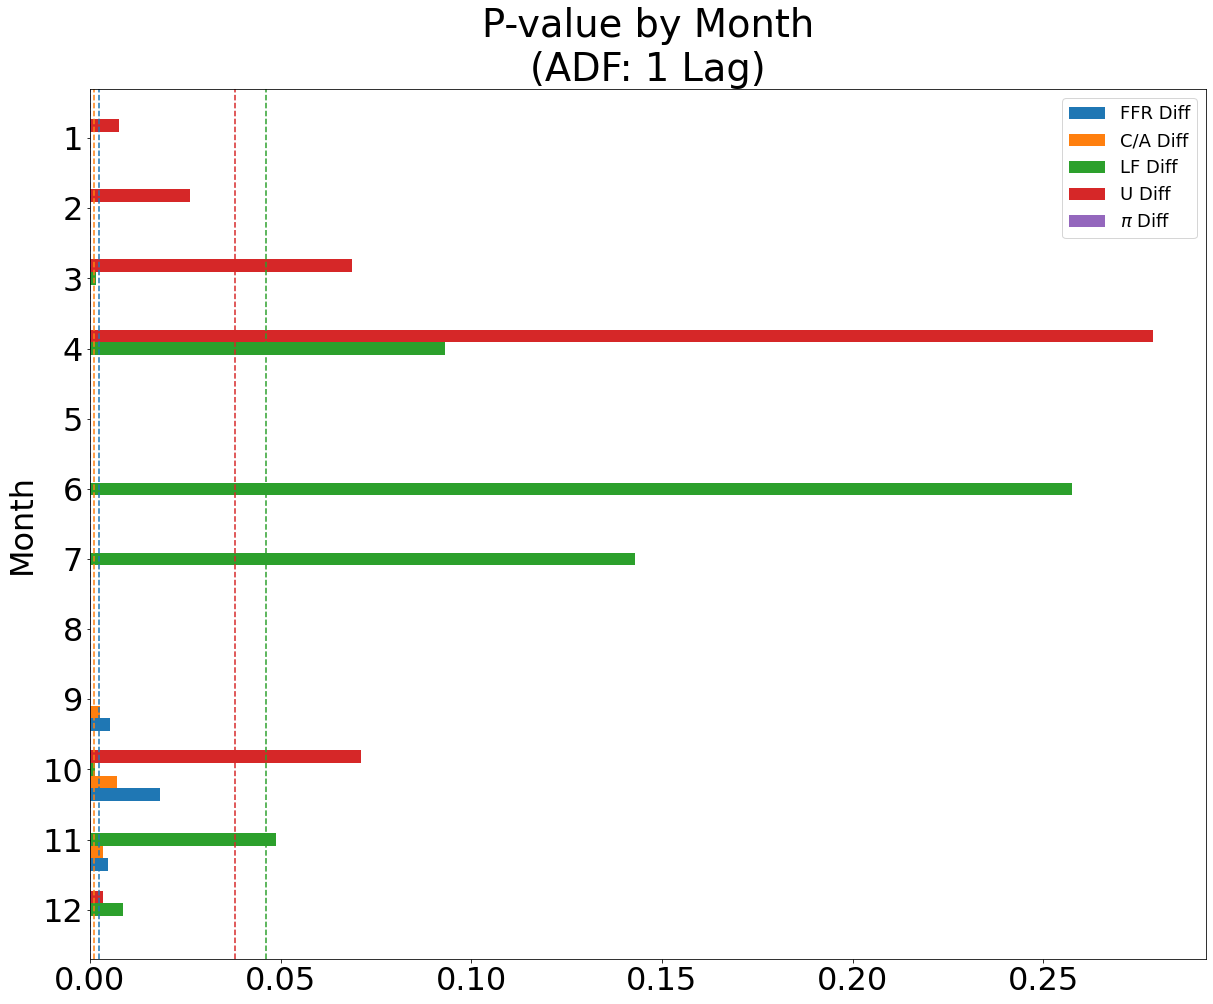

In [29]:
fig,ax = plt.subplots(figsize = (20,16))
adf_dct[" Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).plot.barh(legend = False, width =.9, ax=ax)
plt.legend(fontsize = 18)
title = "P-value by Month\n(ADF: "+str(int(round(12/year,0)))+" Lag)"
plt.title(title)

mean_vals = adf_dct[" Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).mean()
for i in range(len(mean_vals)):
    val = mean_vals[i]
    ax.axvline(val, color = "C" + str(i), ls = "--")

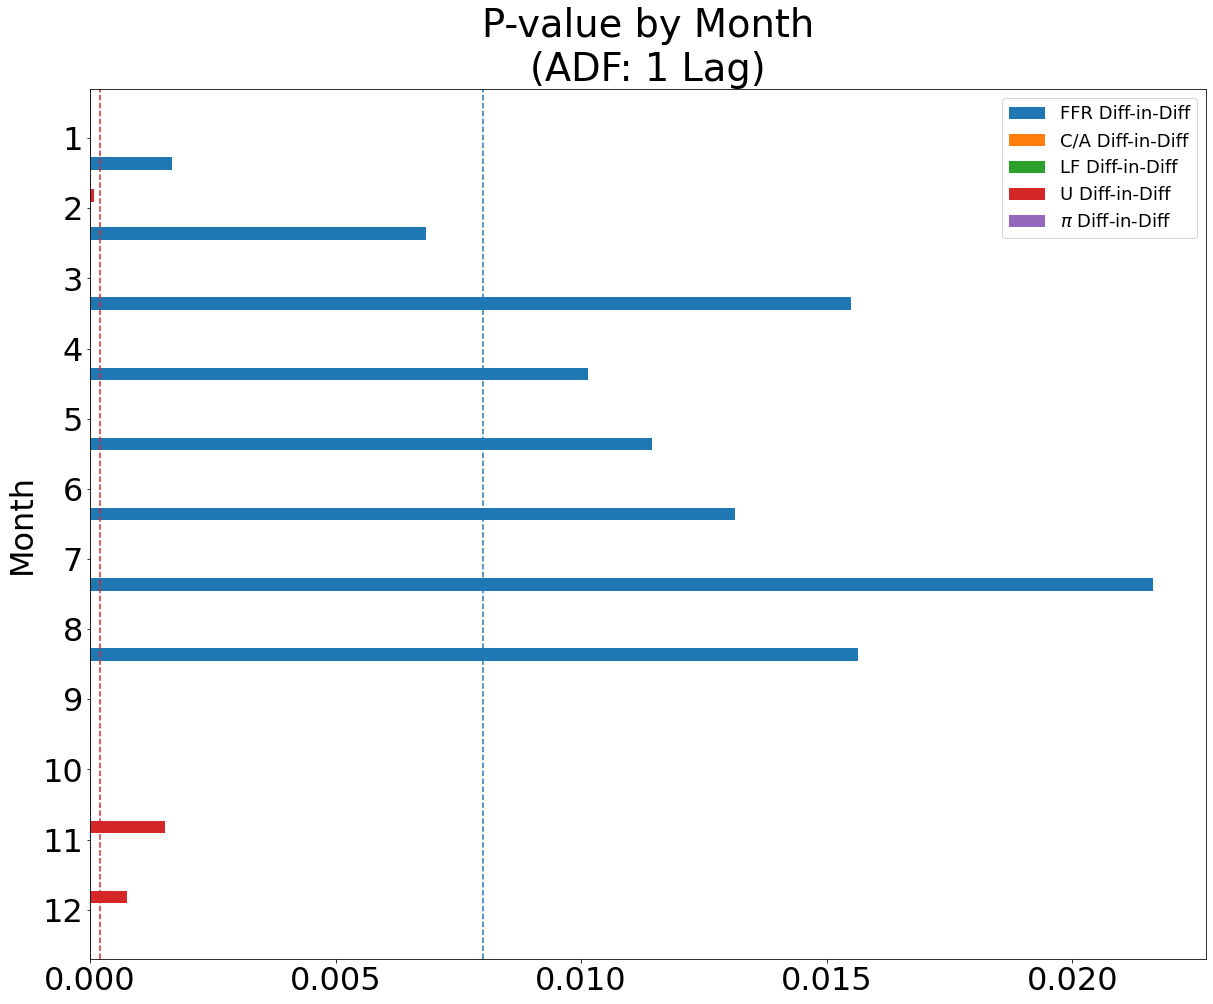

In [30]:
fig,ax = plt.subplots(figsize = (20,16))
adf_dct[" Diff-in-Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).plot.barh(legend = False, width =.9, ax=ax)
plt.legend(fontsize = 18)
plt.title(title)

mean_vals = adf_dct[" Diff-in-Diff"]["Augmented Dickey Fuller"].sort_index(ascending=False).mean()
for i in range(len(mean_vals)):
    val = mean_vals[i]
    ax.axvline(val, color = "C" + str(i), ls = "--")

In [ ]:
data

C:\Users\JLCat\anaconda3\lib\site-packages\pandas\core\frame.py:4441: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-48-ba922d41bac1>:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[new_key] = var_data[key].shift(year * i)
<ipython-input-48-ba922d41bac1>:365: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_data.dropna(inplace=True)
W

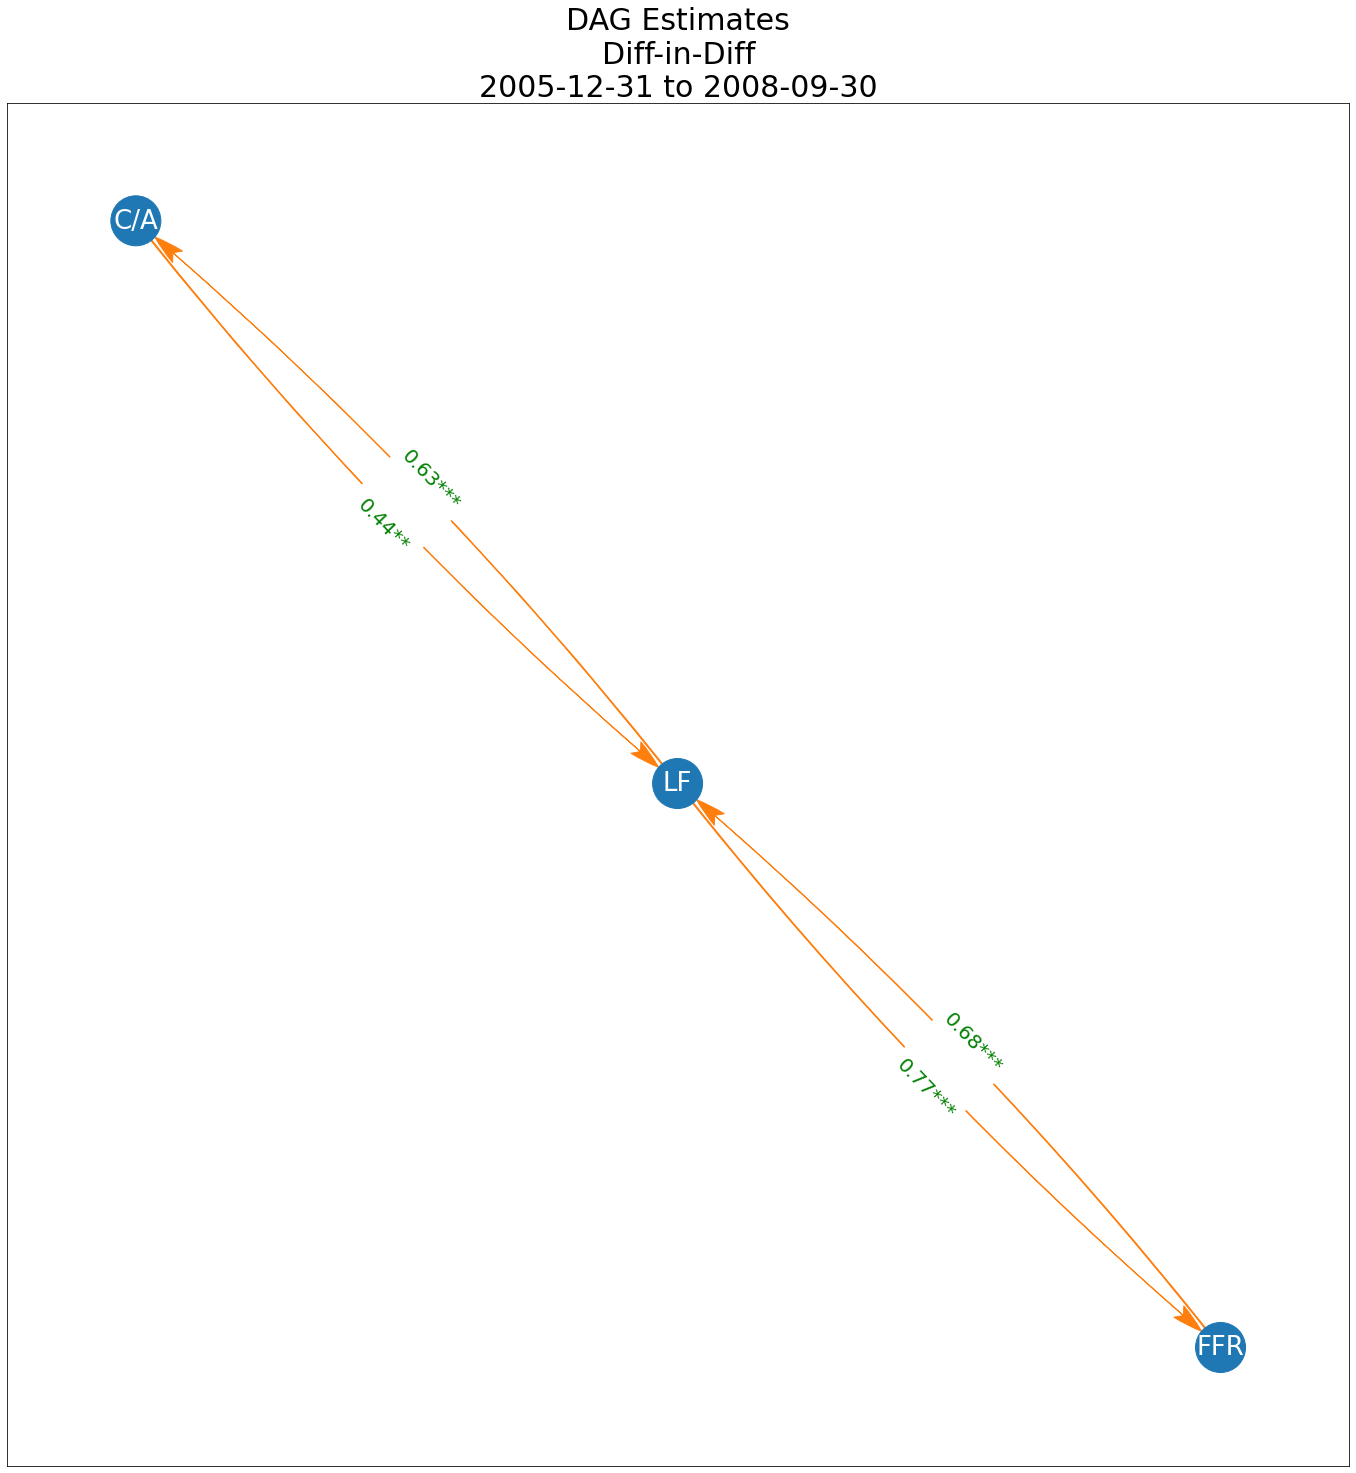

{'LF': 'LF ~ CA + FFR', 'FFR': 'FFR ~ LF', 'C/A': 'CA ~ LF'}
Index(['LF_CA', 'LF_FFR', 'FFR_LF', 'C/A_LF'], dtype='object')


NameError: name 'residuals' is not defined

In [48]:
from collections import OrderedDict
from pgmpy.estimators import PC
from pgmpy.base import DAG
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
from linearmodels.system import SUR
import networkx as nx
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
from sklearn import linear_model
from scipy import stats

class LinearRegression(linear_model.LinearRegression):
    """
    LinearRegression class after sklearn's, but calculate t-statistics
    and p-values for model coefficients (betas).
    Additional attributes available after .fit()
    are `t` and `p` which are of the shape (y.shape[1], X.shape[1])
    which is (n_features, n_coefs)
    This class sets the intercept to 0 by default, since usually we include it
    in X.
    """

    def __init__(self, *args, **kwargs):
        if not "fit_intercept" in kwargs:
            kwargs['fit_intercept'] = False
        super(LinearRegression, self)\
                .__init__(*args, **kwargs)

    def fit(self, X, y, n_jobs=1):
        self = super(LinearRegression, self).fit(X, y, n_jobs)
        self.predictor = self.predict(X) 
        # calculate matrix of same shape as y, use for ssr calculation
        mean_y = np.mean(y, axis = 0)
        mean_y = np.full((self.predictor.shape[0], self.predictor.shape[1]), mean_y)
        self.errors = y - self.predictor
        self.residuals = self.predictor - np.full((self.predictor.shape[0], self.predictor.shape[1]), mean_y)
        sse = np.sum(self.errors ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        ssr = np.sum((self.residuals) ** 2, axis=0) / float(X.shape[0] - X.shape[1])
        sst = sse + ssr 
        se = np.array([
            np.sqrt(np.diagonal(sse[i] * np.linalg.inv(np.dot(X.T, X))))
                                                    for i in range(sse.shape[0])])
        
        self.t = self.coef_ / se
        self.p = 2 * (1 - stats.t.cdf(np.abs(self.t), y.shape[0] - X.shape[1]))        
        self.rsquared = ssr / sst
        print(self.rsquared)
        self.predictor = np.matmul(self.predictor, self.coef_)
        self.residuals = np.matmul(self.residuals, self.coef_)
        return self
def multivariate(endog, exog, sig_vals, constant = True):
    
    if constant:
        exog["Constant"] = 1
    endog_keys= list(endog.keys())
    exog_keys = list(exog.keys())
    reg = LinearRegression().fit(exog, endog)
    residuals = pd.DataFrame(reg.residuals).corr()
    res_keys = list(residuals.keys())
    residuals.rename(columns={res_keys[i]:endog_keys[i] for i in range(len(endog_keys))}, 
                     index = {res_keys[i]:endog_keys[i] for i in range(len(endog_keys))}, inplace = True)
    residuals = residuals.loc[endog_keys, endog_keys]
    print(residuals)
    results = {"coef_":{},
               "t":{}, 
               "p":{}}
    for key in results:
        for i in range(len(endog_keys)):
            endog = endog_keys[i]
            results[key][endog]={}
            for j in range(len(exog_keys)):
                exog = exog_keys[j]
                results[key][endog][exog_keys[j]] = getattr(reg,key)[i][j]
            
# pd.DataFrame([reg.coef_[0],reg.t[0], reg.p[0]], index= endog_keys, columns = exog_keys).T
    keys1 = list(results["coef_"].keys())
    for endog in keys1:
        keys2 = list(results["coef_"][endog].keys())
        for exog in keys2:
            label = ""
            pvalue = results["p"][endog][exog]
            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"
            results["coef_"][endog][exog] = str(round(results["coef_"][endog][exog],3)) + label 
        results["coef_"][endog]["r2"] = reg.rsquared[endog]

    return results["coef_"]#, results["p"]



plt.rcParams.update({"font.size":20})

data = pd.read_parquet("FedDAGData.parquet.gzip")
pd.to_datetime(data['Date'])
data.set_index("Date")

rename_dct = {"Effective":"FFR",
             "Circulation / Total":"C/A",
              "Circulation Growth":"C",
             "Assets Growth":"A",
              "Function":"LF",
             "Inflation":"$\pi$",
             "Unemployment":"U"}

from matplotlib.patches import ArrowStyle
def graph_DAG(edges, df, pp, edge_labels = False, title = ""):
    def build_edge_labels(edges, df):
        edge_labels = {}
        for edge in edges:
            controls = [key for key in df.keys() if key not in edge]
            controls = list(set(controls))
            keep_controls = []
            for control in controls:
                control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
                if (control, edge[1]) in control_edges:
                    keep_controls.append(control)                
#             print(edge, keep_controls)
            pcorr = df.partial_corr(x = edge[0], y = edge[1], covar=keep_controls,
                                  method = "pearson")
            label = str(round(pcorr["r"][0],2))
            pvalue = pcorr["p-val"][0]
#             pcorr = df[[edge[0], edge[1]]+keep_controls].pcorr()
#             label = pcorr[edge[0]].loc[edge[1]]

            sig_vals = [.05, .01, .001]
            for sig_val in sig_vals:
                if pvalue < sig_val: 
                    label = label + "*"   
            
            edge_labels[edge] = label
        return edge_labels
    graph = nx.DiGraph()
    if edge_labels == False:
        edge_labels = build_edge_labels(edges, df) 
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]

    fig, ax = plt.subplots(figsize = (20,20))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)#, k = 5/(len(sig_corr.keys())**.5))

    nx.draw_networkx(graph, pos, node_color=color_map, node_size = 2500,
                     with_labels=True,  arrows=True,
                     font_color = "white",
                     font_size = 26, alpha = 1,
                     width = 1, edge_color = "C1",
                     arrowstyle=ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     connectionstyle='arc3, rad = 0.05',
                     ax = ax)
    
    plt.title(title, fontsize = 30)
#     print(edge_labels)
    edge_labels2 = []
    for u, v, d in graph.edges(data=True):
        if pos[u][0] > pos[v][0]:  
            if (v,u) in edge_labels.keys():
                edge_labels2.append(((u, v,), f'{edge_labels[u,v]}\n\n\n{edge_labels[(v,u)]}'))  
        if (v,u) not in edge_labels.keys():
            edge_labels2.append(((u,v,), f'{edge_labels[(u,v)]}'))
    edge_labels = dict(edge_labels2)

    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='C2')
    
    nx.draw_networkx_edge_labels(graph,pos,
                                 edge_labels=edge_labels,
                                 font_color='green',
                                 font_size=20)
    pp.savefig(fig, bbox_inches = "tight")  
    plt.show()
    plt.close()

def add_lags(data, lags=12 / year):
    for key in data:
        for i in range(1, lags + 1):
            new_key = key +" Lag" * i
            data[new_key] = var_data[key].shift(year * i)

def rename_vars(rename_data, rename_dct):
    for key in rename_data:
        for rename_key in rename_dct:
            if rename_key in key:
                rename_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)                

def DAG(dag_data, variant, ci_test, sig):
    c = PC(dag_data)
#     edges = c.skeleton_to_pdag(*c.build_skeleton())
    max_cond_vars = len(dag_data.keys()) - 2
    model = c.estimate(return_type = "pdag",variant= variant, 
                       significance_level = sig, 
                       max_cond_vars = max_cond_vars, ci_test = ci_test)
    edges = model.edges()
    
    return edges


def identify_sink_nodes(edges):
    unzipped_edges = list(zip(*edges))
    source_nodes = unzipped_edges[0]
    sink_nodes = unzipped_edges[1]
#     sink_nodes = [node for node in sink_nodes if node not in source_nodes]
    caused_causal = {node:[] for node in sink_nodes}
    for source, sink in edges:
        caused_causal[sink].append(source)
    return caused_causal 

def simultaneous_OLS(reg_data, keys, model_type = "DAG"):
    reg_dict={} 
    residuals = {}
    for key in keys:
        reg_dict[key] = {}
        Y = reg_data[[key]]
        X_vars = [k for k in keys if  k != key] if model_type == "DAG" else [k + " Lag" for k in keys]
        X = reg_data[X_vars]
        X["Constant"] = 1
        model = sm.OLS(Y,X)
        results = model.fit()
        residuals[key] = results.resid
        j = 0
        for x_var in X.keys():
            reg_dict[key][x_var] = str(round(results.params[j], 3))
        

        # add * ** *** to sig values
            sig_vals = [.05, .01, .001]
            for sig_val in sig_vals:
                if results.pvalues[j] < sig_val: 
                    reg_dict[key][x_var] = reg_dict[key][x_var] + "*"   
            j+=1
        reg_dict[key]["r2"] = round(results.rsquared,2)
        reg_dict[key]["r2_adj"] = round(results.rsquared_adj,2)
    return reg_dict, residuals

def simultaneous_SUR(reg_data, sink_source, model_type = "DAG", constant = False):
    formulas = {}
    reg_data.rename(columns={key:key.replace("$\pi$","pi").replace("/","") for key in reg_data.keys()},
                    inplace = True) 
    for sink, source in sink_source.items():
        formula = sink.replace("$\pi$","pi").replace("/","") + " ~"
        i= 0
        for x in source:
            if i == 0: 
                formula = formula + " " + x.replace("$\pi$","pi").replace("/","")
            else:
                formula = formula + " + " + x.replace("$\pi$","pi").replace("/","")              
            i=+1

        formulas[sink] = formula
    print(formulas)
    model = SUR.from_formula(formulas, reg_data)
    results = model.fit(cov_type="unadjusted")
    reg_dict = {}
    for ix in results.params.keys():
        sink, source = ix.split("_")
        reg_dict[sink] = {}
    for ix in results.params.keys():
        sink, source = ix.split("_")
        reg_dict[sink][source] = results.params[ix]
    
    return reg_dict, residuals

def DAG_OLS(ols_data, sink_source, filename, pp, constant = False):
    keys = list(ols_data.keys())
    reg_dict, residuals = simultaneous_SUR(ols_data, sink_source)
    if constant: keys = keys + ["Constant"]
    reg_dict = pd.DataFrame(reg_dict).T[keys + ["r2", "r2_adj"]].T
    reg_dict.to_excel(filename + ".xlsx")
    residuals = pd.DataFrame(residuals)    
    res_corr = residuals.corr()
    for key in res_corr:
        res_corr[key][res_corr[key]< 1] = res_corr[key][res_corr[key]< 1] * -1 
    pval_corr = residuals.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)

#     formatted_scatter_matrix(residuals[keys], pp, dates +"\nDAGOLS Residuals")
#     corr_matrix_heatmap(res_corr, pp, dates + "\nDAGOLS Partial Correlations")
#     corr_matrix_heatmap(pval_corr, pp, dates +"\np-values")    

def DAG_VAR(var_data, sink_source, filename, pp):
    reg_dict={}
    residuals = {}
    edges_weights = {}
    sig_vals = [.05, .01, .001]
    
    for sink, source in sink_source.items():
        variables = [sink] + source
        for k in range(len(variables)):
            key = variables[k]
            variables.append(key + " Lag")
            if key in sink_source.keys():
                if sink in sink_source[key] and sink not in variables:
                    variables.append(key)
        select_data = var_data[variables]
        select_data.dropna(inplace = True)
        endog_keys = [key for key in variables if "Lag" not in key]
        exog_keys = [key for key in variables if "Lag" in key]
        endog = select_data[endog_keys]
        exog = select_data[exog_keys]
        reg_dict[sink] = multivariate(endog, exog, sig_vals, constant = False)
        pd.DataFrame(reg_dict[sink])
        for sce in source:
#             print(sce, sink)
#             print(reg_dict[sink])#[sce+ " Lag"])
            edges_weights[(sce, sink)] = reg_dict[sink][sink][sce+ " Lag"]
    graph_DAG(edges = list(edges_weights.keys()), 
              df = select_data,
              edge_labels = edges_weights,
             pp = pp,
             title = "VAR Estimates\n"+diff.replace(" ", "") + "\n" + dates)
    for sink, dct in reg_dict.items():
        print(sink, pd.DataFrame(dct), "", sep = "\n")
        
        lag_keys = [key + " Lag" for key in dct] 
        if "Constant" in dct: lag_keys = lag_keys + ["Constant"]
        excel_df = pd.DataFrame(dct).T[lag_keys +["r2"]].T
        fname = sink + filename  
        excel_df.to_excel(fname.replace("/","").replace("\\","")+".xlsx")
#         residuals_df = pd.DataFrame(residuals[sink]) 
#         res_corr = residuals_df.corr()
#         for key, col in res_corr.items():
#             res_corr[key][res_corr[key]< 1] = res_corr[key][res_corr[key]< 1] * -1 
#         pval_corr = residuals_df.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*res_corr.shape)
#         formatted_scatter_matrix(residuals_df, pp, dates +"\nVAR Residuals")
#         corr_matrix_heatmap(res_corr, pp, dates + "\nVAR Residual Correlations")
#         corr_matrix_heatmap(pval_corr, pp, dates + "\np-values")
    

                
# diffs = [" Diff"," Diff-in-Diff"]
diffs = [" Diff-in-Diff"]
pp = PdfPages("MacroDAGs.pdf")
reg_dict = {}
lags = int(round(12 / year,0))

for diff in diffs:
    reg_dict[diff] = {}
    plot_vars_dct = {"Aggregated C-A": ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      "Aggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
#                      "Disaggregated C-A":["Effective Federal Funds Rate" +diff + " (%)",
#                         "Currency in Circulation / Total Assets" + diff,
#                          "Unemployment Loss" + diff,
#                         "Inflation Loss" + diff],
#                      "Disaggregated C&A":["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }

    sig = 0.2
    variant = "parallel"
    ci_test = "pearsonr"
    
    for i, plot_vars in plot_vars_dct.items():
        reg_dict[diff][i] = {}
        var_data = data[plot_vars]
        rename_vars(var_data, rename_dct)
        add_lags(var_data, lags)
        var_data.dropna(inplace=True)
        start_end_list = [(str(var_data.index[0])[:10],"2008-09-30"),
#                   (str(data.index[0])[:10], "2020-02-29"),
#                   ("2008-10-31", "2020-02-29"),
                  ("2010-01-31", "2020-02-29")]        

        dfs = {}
        for start,end in start_end_list:
            dfs[start +" to " + end] =  var_data.loc[start:end].copy() 

        for dates, select_df in dfs.items():
            keys = [k for k in select_df if "Lag" not in k]
#             simultaneous_SUR(select_df.dropna(), keys, model_type = "VAR")
            dag_df = select_df[keys].dropna()

            edges = DAG(dag_df, variant, ci_test, sig)
            graph_DAG(edges, dag_df, pp = pp, title = "DAG Estimates\n"+diff.replace(" ", "") + "\n" + dates)
            sink_source = identify_sink_nodes(edges)
            filename = i + " " + diff + "DAGOLS " + dates 
            DAG_OLS(dag_df, sink_source, filename, pp)            
            filename = i + " " + diff + "DAGVAR " + dates 
            DAG_VAR(select_df.dropna(), sink_source, filename, pp)
            # run VAR/VARs

    #     print(pd.DataFrame(reg_dict[diff][i]))
pp.close()

In [ ]:
# endog_keys = [key for key in var_data if "Lag" not in key]
# exog_keys = [key for key in var_data if "Lag" in key] 
# endog = var_data.dropna()[endog_keys]
# exog = var_data.dropna()[exog_keys]
# sig_vals = [.05, .01, .001]
# results = multivariate(endog, exog, sig_vals, constant = True)
# pd.DataFrame(results["coef_"])


In [ ]:
print(linear_model.LinearRegression)

In [ ]:
var_data

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
var_data.rename(columns={key:key.replace(" Diff-in-Diff", "") for key in var_data}).loc["2008-10-31":"2020-02-29"].plot.scatter(
                                                x = "FFR", 
                                                 y = "C/A", 
                                                 c = "LF", 
                                                 cmap = "viridis", 
                                                 ax = ax)
ax.set_title("January 2010 - July 2020")

In [ ]:
fig, ax = plt.subplots(figsize = (14,8))
data[data["Effective Federal Funds Rate (%)"] <= 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C0", 
                                                 ax = ax)
data[data["Effective Federal Funds Rate (%)"] > 0.25].loc["2010-01-31":"2020-02-29"].plot.scatter(x = "Currency in Circulation / Total Assets Diff-in-Diff", 
                                                 y = "Unemployment Rate Diff-in-Diff", 
                                                 c = "C2", 
                                                 ax = ax)

In [ ]:
from statsmodels.tsa.api import VAR
plt.rcParams.update({"font.size":12})

diffs = ["", " Diff"]
pp = PdfPages("VARPlots.pdf")

for diff in diffs:
    plot_vars_dct = {0: ["Effective Federal Funds Rate" +diff + " (%)",
                         "Currency in Circulation / Total Assets" + diff,
                        "Loss Function" + diff],
#                      1:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Loss Function" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                     2:["Effective Federal Funds Rate" +diff + " (%)",
                        "Currency in Circulation / Total Assets" + diff,
                         "Unemployment Loss" + diff,
                        "Inflation Loss" + diff],

#                      3:["Currency in Circulation Growth Rate" +diff + " (%)",
#                         "Unemployment Loss Sq" + diff,
#                         "Inflation Loss Sq" + diff,
#                         "Effective Federal Funds Rate" +diff + " (%)",
#                         "Total Assets Growth Rate" +diff + " (%)"],
                    }
    for i in plot_vars_dct:
        var_data = data[plot_vars_dct[i]].dropna().loc["2009-07-31":"2020-02-29"]#.resample("Q").last()
        for key in var_data:
            for rename_key in rename_dct:
                if rename_key in key:
                    var_data.rename(columns={key:rename_dct[rename_key]}, inplace = True)
        model = VAR(var_data)
#         model.select_order(12)
#         results = model.fit(maxlags=24, ic='aic')
        results = model.fit(12)
        formatted_scatter_matrix(results.resid, pp)
        corr_matrix_heatmap(results.resid.corr(), pp)
        print(results.summary())
        
#         print(results.test_causality("Effective Federal Funds Rate" +diff + " (%)", ['realinv', 'realcons'], kind='f')
#         fig = results.plot_acorr(24)        
#         pp.savefig(fig)
        irf = results.irf(24)        
        fig = irf.plot(orth=False, figsize = (20,12))
        pp.savefig(fig)
        fig = irf.plot_cum_effects(orth=False, figsize = (20,12))
        pp.savefig(fig)
        #         irf.plot_cum_effects(orth = False)
#         for key in var_data.keys():
#             irf.plot(orth = False, impulse=key)
#             irf.plot_cum_effects(orth=False, impulse = key)
pp.close()       


In [ ]:
data.iloc[70]

In [ ]:
figsize = (20,12)
fig,ax = plt.subplots(figsize = figsize)

ax2 = ax.twinx()
ax3 = ax.twinx()
data[["Currency in Circulation / Total Assets"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax)
data[["Effective Federal Funds Rate (%)"]].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .8,
                                                      ax = ax2,
                                                        c = "C1")
data[["Loss Function"]].iloc[:-1].plot(legend = False, 
                                                      linewidth = 5, 
                                                      alpha = .1,
                                                      ax = ax3,
                                                        c = "k")

ax.set_yticklabels([str(int(val )) + "%" for val in ax.get_yticks()], c = "C0")
ax2.set_yticklabels([str(int(val)) + "%" for val in ax2.get_yticks()], c = "C1")
ax3.set_yticklabels(ax3.get_yticks(), alpha = .2, c = "k")
ax3.set_yticks([])

ax3.axhline(0, c = "k", alpha = .1, linewidth = 5, ls = "--")

plt.axvline(datetime.datetime(2008,10,1), c = "k", ls = "--", alpha = .9)
ax.text(datetime.datetime(2013,3,1), 42, "Currency in Circulation\n/  \nTotal Assets", fontsize = 25, c = "C0", 
        ha = "center")
ax.text(datetime.datetime(2018,5,1), 58, "Effective\nFederal\nFunds\nRate", fontsize = 25, c = "C1", 
        ha = "center")
ax.text(datetime.datetime(2014,6,1), 78, "Loss\nFunction", fontsize = 25, c = "k", alpha = .3, 
        ha = "center")
ax.text(datetime.datetime(2002,10,10), 93.5, "0", fontsize = 30, c = "k", alpha = .3, 
        ha = "right")
ax.text(datetime.datetime(2021,9,1), 93.5, "0 ", fontsize = 30, c = "k", alpha = .3, 
        ha = "left")

In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
data[["Linear Loss Diff", "Total Assets Growth Rate (%)"]].plot.scatter(x = "Linear Loss Diff", y = "Total Assets Growth Rate (%)", ax = ax)
plt.xticks(rotation=90)


In [ ]:
fig, ax = plt.subplots(figsize = (30,15))
data.iloc[:-1].plot.scatter(x = "Linear Loss", y = "Currency in Circulation / Total Assets", ax = ax)
plt.xticks(rotation=90)


In [ ]:
data